# BaBar $\sigma(e^+e^- \rightarrow \pi^+\pi^- (\gamma))$

The latest BaBar measurements are published in two papers, a PRL and a later PRD containing more detailed information. Both papers report the cross-section information in the supplemental material, in ASCII files that are identical.

* B. Aubert et al. \[BaBar Collaboration\], [Phys. Rev. Lett. 103 (2009) 231801](https://doi.org/10.1103/PhysRevLett.103.231801), [inspirehep](http://inspirehep.net/record/829441),<br />
"Precise measurement of the e+ e- ---> pi+ pi- (gamma) cross section with the Initial State Radiation method at BABAR"

* J. P. Lees et al. \[BaBar Collaboration\], [Phys. Rev. D 86 (2012) 032013](https://doi.org/10.1103/PhysRevD.86.032013), [inspirehep](http://inspirehep.net/record/1114155),<br />
"Precise Measurement of the e+e− → π+π−(γ)e+e−→π+π−(γ) Cross Section with the Initial-State Radiation Method at BABAR"
  * [supplemental material folder](http://ftp.aip.org/epaps/phys_rev_lett/E-PRLTAO-103-045950/)
    * [BABAR_ISR2pi_EPAPS.txt](http://ftp.aip.org/epaps/phys_rev_lett/E-PRLTAO-103-045950/BABAR_ISR2pi_EPAPS.txt)

The data report the "**bare cross section including FSR**" in nb, and in detail:
* the cross-section and its total undertainty in variable-width bins of energy
* the per-mil relative systematic uncertainty (per energy bin, 100% correlated on all bins)
* the statistical correlation between any two bins of cross-section

In the following the data are used to show a few plots.

<!-- TEASER_END -->

In [23]:
using DataFrames
## using DataFramesMeta

using TextParse
using CSV

using FileIO

## using Plots
using StatsPlots
using Measures

using LaTeXStrings
using Query

In [24]:
##
## configure plots
##

## const PLOTS_DEFAULTS = Dict(:theme => :juno)

Plots.default(
  size = (700, 400),
  framestyle = :box,
  tickdirection = :out,
  top_margin = 4pt,
  bottom_margin = 4pt,
  left_margin = 4pt,
  right_margin = 10pt,
)

Plots.pyplot()
## Plots.GRBackend()

Plots.PyPlotBackend()

In [25]:
##
## defs and functions
##

In [26]:
##
## readlines_enh() enhanced readlines() function
## - <skipto> begin reading from indicated line
## - <limit> number of lines to read
##
function readlines_enh(filename::AbstractString; skipto=1, limit=Inf, kw...)
  open(filename) do f
    readlines_enh(f, skipto=skipto, limit=limit; kw...)
  end
end
##
## readlines_enh() from file stream
##
readlines_enh(s=stdin; skipto=1, limit=Inf, kw...) =
  collect(Iterators.take(Iterators.drop(eachline(s; kw...), skipto-1), limit))
nothing

In [27]:
##
## get extrema and extend them by desired amount
##
function extrema_ext(A, ext)
  a, b = extrema(A)
  marg = (b-a)*ext
  a-marg, b+marg
end

extrema_ext (generic function with 1 method)

In [28]:
##
## code
##

In [29]:
##
## download BaBar Phys. Rev. D 86 (2012) 032013 suppl. mat.
##
tmpfile = download("http://ftp.aip.org/epaps/phys_rev_lett/E-PRLTAO-103-045950/BABAR_ISR2pi_EPAPS.txt")

"/tmp/jl_q3MDL5"

In [30]:
##
## read cross-section val and unc of cross-section by energy bin
## - data in lines 30..366
## - format: "2.8  : 2.9           0.009181                 0.0132598"
##
df = DataFrame!(CSV.File(
  tmpfile,
  skipto=30, limit=337, delim=' ', ignorerepeated=true,
  header=[:E_l, :colon, :E_h, :sigma_val, :sigma_stat_unc]
))
select!(df, Not(:colon))

##--- compute mid-bin energy
transform!(df, [:E_l, :E_h] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E)

display(first(df, 4))
nothing

,E_l,E_h,sigma_val,sigma_stat_unc,E
,Float64,Float64,Float64,Float64,Float64
1,0.3,0.31,25.4904,2.69943,0.305
2,0.31,0.32,35.4801,2.91464,0.315
3,0.32,0.33,45.4858,3.04669,0.325
4,0.33,0.34,51.7825,3.13355,0.335


In [31]:
##
## read cross-section systematic uncertainties
##

##
## read 1 line reporting energy intervals [E_l, E_h] for systematic contributions
## resulting DataFrame ha 1 row with 8 strings of rormat E_l_i,E_h_i 
##
df_tmp = DataFrame!(CSV.File(
  tmpfile,
  skipto=388, limit=1, delim=' ', ignorerepeated=true,
  header=false
))
##
## convert first row of df_tmp into a vector and then a newline-separated stream
## and then read the stream as a DF with two columns E_l, E_h and 8 rows
##
df_syst = DataFrame!(CSV.File(IOBuffer(join(Vector(df_tmp[1, :]), "\n")), header=[:E_l, :E_h], delim='-'))

##
## read line with systematic unc's for the just read energy intervals, 8 numbers in parenthesis
##
line_tmp = readlines_enh(tmpfile, skipto=401, limit=1)
line_tmp = strip(replace(line_tmp[1],  r"\(([^\)]*)\)" => s"\1"))
##--- read numeric values into DF with 1 row and 8 columns
df_tmp = DataFrame!(CSV.File(IOBuffer(convert(String, line_tmp)),
    delim=' ', ignorerepeated=true, header=false))
##--- remove columns with no data
## df_tmp = df_tmp[!, eltype.(eachcol(df_tmp)) .!= Missing]
##--- add total systematic uncertainties to DF of syst. uncert.
df_syst.unc = Vector(df_tmp[1, :])
##--- compute and add to DF the energy bins mid points
transform!(df_syst, [:E_l, :E_h] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E)
display(first(df_syst, 4))
nothing

,E_l,E_h,unc,E
,Float64,Float64,Float64,Float64
1,0.3,0.4,13.8,0.35
2,0.4,0.5,8.1,0.45
3,0.5,0.6,10.2,0.55
4,0.6,0.9,5.0,0.75


In [32]:
##
## return first index for which x is in the range of lower[row]..upper[row]
##
function findbin(x::AbstractFloat, lower::AbstractArray, upper::AbstractArray)
  nrow = length(lower)
  nrow == length(upper) || throw("lower / upper size mismatch")
  for row in 1:nrow
    if (x >= lower[row] && x <= upper[row])
      return row
    end
  end
  return nothing
end

findbin (generic function with 1 method)

In [33]:
##
## add systematic uncertainty to cross-section DF
##

function val(E)
  row = findbin(E, df.E_l, df.E_h)
  ifelse(isnothing(row), missing, df.sigma_val[row])
end

##--- get syst covariance as function of two energies: non-zero only for diagonal elements
function syst_cov(E_x, E_y)
  row = findbin(E_x, df_syst.E_l, df_syst.E_h)
  col = findbin(E_y, df_syst.E_l, df_syst.E_h)
  if (isnothing(row) || isnothing(col))
    return missing
  end
  if (row == col)
    ##--- uncertainty is quoted relative in permille
    return val(E_x) * val(E_y) * (df_syst[row, :unc]/float(1000))^2
  else
    return float(0)
  end
end

##--- get syst correlation as function of two energies: non-zero only for diagonal elements
function syst_corr(E_x, E_y)
  row = findbin(E_x, df_syst.E_l, df_syst.E_h)
  col = findbin(E_y, df_syst.E_l, df_syst.E_h)
  if (isnothing(row) || isnothing(col))
    return missing
  end
  if (row == col)
    return float(1)
  else
    return float(0)
  end
end

##--- get syst unc for any energy, finding the correct systematic unc bin
function syst_unc(E)
  row_match = findbin(E, df_syst.E_l, df_syst.E_h)
  ifelse(isnothing(row_match), missing, val(E)*df_syst[row_match, :unc]/float(1000))
end

##
## add syst. and total unc.
##
df.sigma_syst_unc = syst_unc.(df.E)
df.sigma_unc = sqrt.(df.sigma_stat_unc.^2 + df.sigma_syst_unc.^2)

display(first(df, 4))

,E_l,E_h,sigma_val,sigma_stat_unc,E,sigma_syst_unc,sigma_unc
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.3,0.31,25.4904,2.69943,0.305,0.351768,2.72225
2,0.31,0.32,35.4801,2.91464,0.315,0.489626,2.95548
3,0.32,0.33,45.4858,3.04669,0.325,0.627704,3.11068
4,0.33,0.34,51.7825,3.13355,0.335,0.714598,3.214


In [53]:
##
## the txt file lists the statistical covariance row by row using the energy bins
## defined for reporting the cross section
## there are N energy bins, the covariance is a matrix with rows and colums
## the first values are for columns 1:N and row=1
## the next values are for columns 1:N and row=2 and so on
##
if true
  ##
  ## get statistical covariance
  ##
  df_stat = DataFrame!(CSV.File(
    tmpfile,
    skipto=406, limit=337*337, delim=' ', ignorerepeated=true,
    header=false, use_mmap=false
  ))
else
  ##
  ## alternative way of getting stat. cov.
  ##
  df_stat = DataFrame(cov = parse.(Float64, strip.(
      readlines_enh(tmpfile, skipto=407, limit=337*337))))
end

true

In [36]:
##
## build a dataframe where for each covariance coefficient we have:
## - column central energy, low edge of energy bin, high edge of energy bin
## - same as above for the row
## this dataframe is used for doing a contour plot
##

df_stat.E_l_c = repeat(df.E_l, outer=nrow(df))
df_stat.E_h_c = repeat(df.E_h, outer=nrow(df))
df_stat.E_l_r = repeat(df.E_l, inner=nrow(df))
df_stat.E_h_r = repeat(df.E_h, inner=nrow(df))
transform!(df_stat, [:E_l_c, :E_h_c] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E_c)
transform!(df_stat, [:E_l_r, :E_h_r] => ( (E_l, E_h) -> (E_l+E_h)/2 ) => :E_r)

display(first(df_stat, 4))
nothing

,cov,E_l_c,E_h_c,E_l_r,E_h_r,E_c,E_r
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,7.16412,0.3,0.31,0.3,0.31,0.305,0.305
2,0.811213,0.31,0.32,0.3,0.31,0.315,0.305
3,0.0292493,0.32,0.33,0.3,0.31,0.325,0.305
4,0.216073,0.33,0.34,0.3,0.31,0.335,0.305


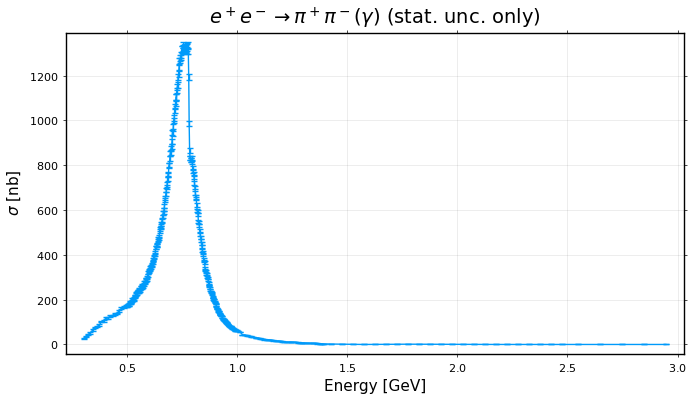

In [37]:
##
## plot cross-section vs. energy (stat. unc. only)
##
pl1 = @df df plot(
  :E,
  :sigma_val,
  yerror=:sigma_stat_unc,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$ (stat. unc. only)",
  xlabel="Energy [GeV]",
  ylabel=L"$\sigma$ [nb]",
  markerstrokecolor = :auto,
  legend = false
)
## savefig(pl1, "plot.pdf")
## display(pl1)

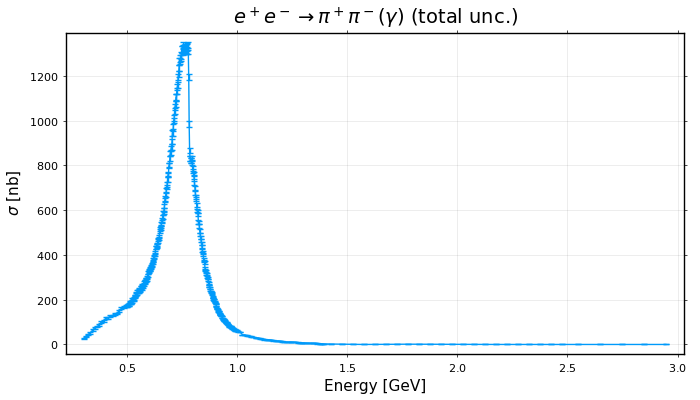

In [38]:
##
## plot cross-section vs. energy (total unc.)
##
pl1tot = @df df plot(
  :E,
  :sigma_val,
  yerror=:sigma_unc,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$ (total unc.)",
  xlabel="Energy [GeV]",
  ylabel=L"$\sigma$ [nb]",
  markerstrokecolor = :auto,
  legend = false
)
## savefig(pl1tot, "plot.pdf")
## display(pl1tot)

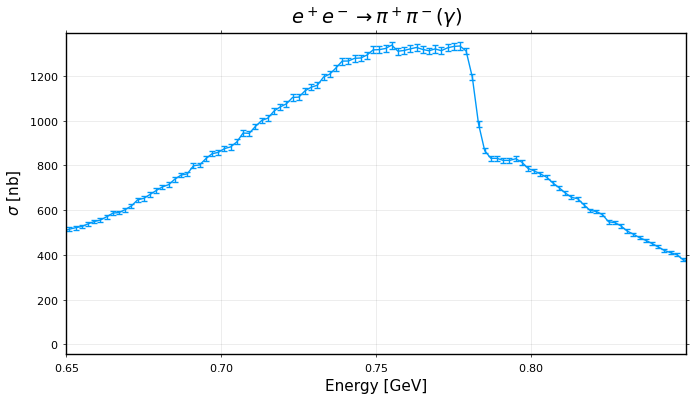

In [39]:
##
## plot cross-section vs. energy around rho / omega interference
##
pl2 = @df df plot(
  :E,
  :sigma_val,
  yerror=:sigma_unc,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$",
  xlabel="Energy [GeV]",
  ylabel=L"$\sigma$ [nb]",
  markerstrokecolor = :auto,
  legend = false,
  xlim=(0.65,0.85)
)
## savefig(pl2, "plot.pdf")
## display(pl2)

In [40]:
##
## plot statistical covariance surface plot
##
pl3 = @df df_stat surface(
  :E_c,
  :E_r,
  :cov,
  title=L"$e^+e^- \rightarrow \pi^+\pi^-(\gamma)$",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  ## zlabel="σ covariance",
  camera=(0, 90),
  clims = (minimum(:cov)-0.2*(maximum(:cov)-minimum(:cov)), maximum(:cov)+0.2*(maximum(:cov)-minimum(:cov)))
)
nothing

In [41]:
##
## functions for producing contour plots of stat covariance
##

##--- get covariance as function of two energies
function stat_cov(E_x, E_y)
  row = findbin(E_x, df.E_l, df.E_h)
  col = findbin(E_y, df.E_l, df.E_h)
  if (row == nothing || col == nothing)
    return missing
  end
  ##
  ## interpret cov values vector as matrix with n rows and n columns
  ## return appropriate cov value for required row and column
  ##
  reshape(df_stat.cov, (nrow(df), nrow(df)))[row, col]
end

stat_cov_clims = @df df identity( extrema_ext((stat_cov(Ex, Ey) for Ex in :E, Ey in :E), 0.2) )

##--- get correlation as function of two energies
function stat_corr(E_x, E_y)
  row = findbin(E_x, df.E_l, df.E_h)
  col = findbin(E_y, df.E_l, df.E_h)
  if (row == nothing || col == nothing)
    return missing
  end
  matr_stat = reshape(df_stat.cov, (nrow(df), nrow(df)))
  matr_stat[row, col] / sqrt(matr_stat[row, row]*matr_stat[col, col])
end

stat_corr_clims = @df df identity( extrema_ext((stat_corr(Ex, Ey) for Ex in :E, Ey in :E), 0.2) )

nothing

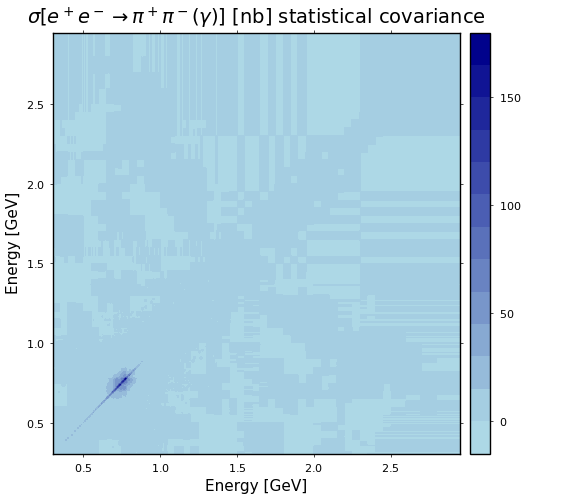

In [42]:
##
## plot statistical covariance contour plot
##
pl3 = @df df contourf(
  ## :E, :E,
  range(extrema(:E)..., length=500),
  range(extrema(:E)..., length=500),
  stat_cov,
  ## clims = stat_cov_clims,
  color = :blues,
  title=L"$\sigma[e^+e^- \rightarrow \pi^+\pi^-(\gamma)]$ [nb] statistical covariance",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  size=(575, 500)
)

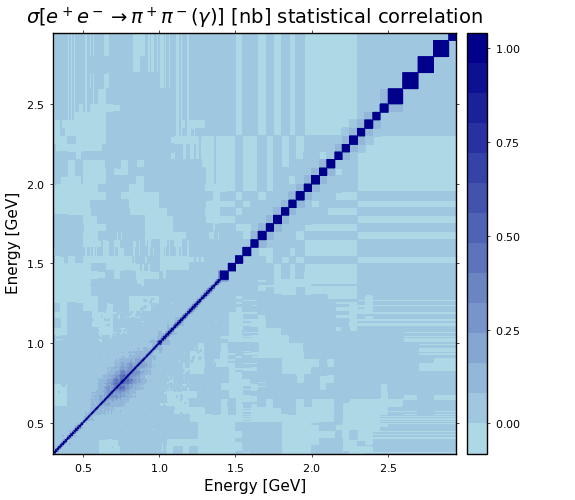

In [43]:
##
## plot statistical correlation contour plot
##
pl3 = @df df contourf(
  ## :E, :E,
  range(extrema(:E)..., length=500),
  range(extrema(:E)..., length=500),
  stat_corr,
  ## clims = stat_corr_clims,
  color = :blues,
  title=L"$\sigma[e^+e^- \rightarrow \pi^+\pi^-(\gamma)]$ [nb] statistical correlation",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  size=(575, 500)
)

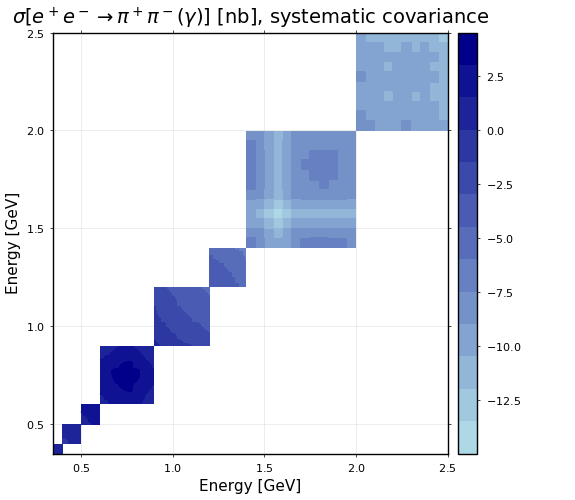

In [44]:
##
## plot systematic covariance contour plot
## there is no systematic covariance, just diagonal systematic uncertainties
##

syst_cov_clims = @df df_syst identity( extrema_ext((syst_cov(Ex, Ey) for Ex in :E, Ey in :E), 0.2) )
## println("range of covariance values:", cov_clims)
## println("note: color legend is not accurate, does not match custom color limits ", syst_cov_clims)

##
## plot
##
pl4 = @df df_syst contourf(
  ## :E, :E,
  range(extrema(:E)..., length=500),
  range(extrema(:E)..., length=500),
  (x, y) -> log(syst_cov(x, y)),
  ## clims = syst_cov_clims,
  color = :blues,
  ## levels = exp.(range(log.(extrema(df_syst.E))..., length=10)),
  title=L"$\sigma[e^+e^- \rightarrow \pi^+\pi^-(\gamma)]$ [nb], systematic covariance",
  xlabel="Energy [GeV]",
  ylabel="Energy [GeV]",
  size=(575, 500),
)